# Performance comparison of 2D finite difference wave propagation implementations
*by [Alan Richardson](mailto:alan@ausargeo.com) ([Ausar Geophysical](http://www.ausargeo.com))*

I [previously](https://github.com/ar4/wave_1d_fd_perf/blob/master/notebooks/wave_1d_fd_perf.ipynb) investigated the performance of 1D finite difference wave propagation implemented using Python, Numba, C and Fortran (and, [in another notebook](https://github.com/ar4/wave_1d_fd_tf/blob/master/notebooks/wave_1d_fd_tf.ipynb), TensorFlow). This notebook is the same idea, but this time we are expanding into the second dimension.

Once again, I will be using a high-order finite difference scalar wave equation propagator, with hard boundaries to keep the code simple. The code gets called from Python, to simulate the situation where most of a RTM/FWI code is written in Python, and the computationally expensive wave propagation component is written in something that gives better performance. One change from the 1D notebook is that I won't be considering Python, Numba, or TensorFlow for the wave propagation implementation. They were pretty slow in 1D, so I don't want to try them in 2D.

The different implementations vary only in the way the code is written, attempting to enhance vectorization or reduce cache misses. I am thus not considering the possibility that you might get better performance by changing the propagator to something other than standard finite difference.

The performance of finite difference codes is typically limited by memory bandwidth. A lot of values are required from memory for each calculation, and the calculations are very simple. That means that the CPU cores spend much of their time idle, waiting for data to arrive. It is therefore likely that the most promising performance optimizations are those that reduce unnecessary memory accesses.

I use compiler options that may affect numerical accuracy, such as `-Ofast`, but in all cases, the wavefield after propagating for 0.2 s (333 time steps) is within `5e-4` of the wavefield when propagating with the most obvious implementation (VC1 below) compiled using `-O2`. In fact, the difference in the output is larger between the most conservative C and Fortran versions than between all of the C versions.

With the exception of one (VC6_256), all of the implementations are strictly standards compliant and so it should be possible to compile them with any compiler. Another one, VC15, includes a GCC-specific `#pragma`, but that shouldn't stop it compiling with other compilers.


## Implementations

I tried quite a few different implementations and won't go through all of them.

### [VC1](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vc1.c)
This is the most obvious way of implementing the method using C. It primarily consists of four loops: the outer loop is over time steps, inside that is a loop over `y`, inside that a loop over `x`, and inside that there is, among other things, a loop over the finite difference coefficients that are used to calculate the spatial derivative of the wavefield. The code is clear and concise (only 64 lines).

### [VC2](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vc2.c)
The only way in which VC2 differs from VC1 is the inner loop. Instead of having a loop over the finite difference coefficients, I have manually unrolled the loop. The advantage of this is that it makes it very clear to the compiler that all of the memory accesses needed for the computation can be done simultaneously and none of the intermediate results need to be written to memory. This makes the code longer (96 lines), uglier, and less flexible (changing the order of the finite difference stencil requires more than just updating the end condition of a loop now). Surely this is terrible coding practice? Perhaps, but in High Performance Computing, unlike in most other fields, processing time is more expensive than programmer time. Spending a day to get a 5% performance improvement is often worthwhile for a code that is going to run almost continuously on thousands of cores. The other argument against this type of optimization is that it should surely have been done by the compiler. I would have thought that likely too - it seems obvious that it is safe to unroll this loop, but we shall have to wait for the results to see if that is the case.

### [VC3](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vc3.c), [VC4](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vc4.c)
These are the same as VC1 and VC2, respectively, with the modification of moving the computation inside the time step loop into a separate function. GCC reported that it could not vectorize the computation because it wasn't able to determine that there were no dependencies. I guessed that this was due to the pointer swapping that happens at the end of each time step (the memory that was the wavefield at the current time step is now the wavefield at the previous time step). GCC reports that it does vectorize these versions. It is possible to explicitly tell the compiler that it is safe to vectorize with `#pragma GCC ivdep`. I verified with [VC15](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vc15.c) that it does then vectorize without creating a new function, but I prefer to avoid compiler-specific extensions when possible.

### [VC6](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vc6.c)
This is VC4 with OpenMP parallelization of the loop over `y`, ensuring that all of the cores, and, more importantly, all of the cache storage and memory bandwidth, is used.

### [VC8](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vc8.c)
VC6 is extended to use blocking over `x` and `y`. Instead of completing all of one row before starting on the next, with blocking the calculation is performed on small 2D blocks. The calculation for cell `[x, y]` requires data from cells between `[x - 8, y]` and `[x + 8, y]`, but also from `[x, y - 8]` to `[x, y + 8]`. These values will be stored in cache after the computation. If the computation continues on along the row, the columns (different `y` values) of data will not be used again until the computation starts on the next row. For long rows, the columns will probably have been erased from the cache memory by then, and so that data will need to be loaded from main memory again. By working in 2D blocks, a higher percentage of the data used in the computations will already be in the cache when it is needed, reducing memory bandwidth consumption and latency.

### [VC11](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vc11.c)
This is equivalent to VC4 from my 1D notebook. It is like this notebook's VC6, but instead of OpenMP being applied to the `y` loop, an OpenMP parallel region is created around the time step loop. This makes the code more complicated, but has the advantages of avoiding the need to create and destroy threads every time step and allowing sources to be added by the threads that "own" the part of the domain where they are located (with potential memory access benefits).

### [VF1](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vf1.f90), [VF2](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vf1.2.f90)
These are the Fortran equivalents of VC1 and VC2.

### [VF3](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vf3.f90), [VF5](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vf5.f90)
In VF3, Fortan 95's `forall` is used for the loops over `x` and `y`, while VF5 does the same but with Fortran 2008's `do concurrent`. To indicate to the compiler that the operations inside these loops do not have side-effects, the operations they contain are moved into separate `pure` functions.

### [VF4](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vf4.f90), [VF6](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vf6.f90)
These are the same as VF3 and VF5, respectively, but without moving the operations into separate functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from wave_2d_fd_perf import propagators, test_wave_2d_fd_perf, run_timing, run_timing_blocksize
from wave_2d_fd_perf.propagators import (VC1_O2_gcc, VC1_O3_gcc, VC1_Ofast_gcc, VC2_O2_gcc, VC2_O3_gcc, VC2_Ofast_gcc, VC3_Ofast_gcc, VC3_Ofast_unroll_gcc, VC4_Ofast_gcc, VC4_Ofast_extra1_gcc, VC4_Ofast_extra2_gcc, VC4_Ofast_extra3_gcc, VC5_Ofast_gcc, VC6_Ofast_gcc, VC6_Ofast_256_gcc, VC7_Ofast_gcc, VC8_Ofast_gcc, VC9_Ofast_gcc, VC10_Ofast_gcc, VC11_Ofast_gcc, VC12_Ofast_gcc, VC13_Ofast_gcc, VC14_Ofast_gcc, VC15_Ofast_gcc, VF1_O2_gcc, VF1_O3_gcc, VF1_Ofast_gcc, VF2_Ofast_gcc, VF3_Ofast_gcc, VF4_Ofast_gcc, VF5_Ofast_gcc, VF6_Ofast_gcc, VF6_Ofast_autopar_gcc)
from wave_2d_fd_perf.propagators import (VC8a_Ofast_gcc, VC9a_Ofast_gcc, VC10a_Ofast_gcc)

## Results

The performance of the codes depends greatly on where it is run and what compiler was used. I generated the results below using the following system (which is a cloud instance).

In [12]:
!lscpu

Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                8
On-line CPU(s) list:   0-7
Thread(s) per core:    1
Core(s) per socket:    8
Socket(s):             1
NUMA node(s):          1
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 63
Model name:            Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz
Stepping:              2
CPU MHz:               2394.414
BogoMIPS:              4788.82
Hypervisor vendor:     Microsoft
Virtualization type:   full
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              30720K
NUMA node0 CPU(s):     0-7
Flags:                 fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx lm constant_tsc rep_good nopl eagerfpu pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm fsgsbase bmi1 avx2 sm

In [33]:
!gcc --version

gcc (Ubuntu 5.4.0-6ubuntu1~16.04.4) 5.4.0 20160609
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



### Block size

VC8 uses cache blocking, but for this to be effective we need to tune the block size. With multiple levels of cache, some shared by multiple threads running in parallel, it is not obvious what block size will work best.

We need to tune both the block size in the `x` (fast) dimension, and also in the `y` (slow) dimension. To do this I will simply run the propagator for different block size combinations and measure the run time. To avoid tuning for a specific model size (if a specific block size divides evenly into the model size, it will probably run faster), I run each block size combination with several different model sizes and sum the run times.

In [4]:
blocksizes_y = [1, 8, 16, 32, 64]
blocksizes_x = [8, 16, 32, 64, 128, 256, 512]
t8 = run_timing_blocksize.run_timing_model_size(num_repeat=5, num_steps=10, model_sizes=range(2000, 2500, 5), versions=[{'class': VC8a_Ofast_gcc, 'name': '8'}], blocksizes_y=blocksizes_y, blocksizes_x=blocksizes_x, align=256)

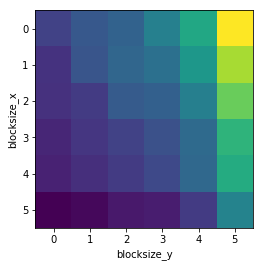

In [7]:
ax = plt.subplot(111)
plt.imshow(t8.groupby(['blocksize_y', 'blocksize_x']).mean()['time'].values.reshape(len(blocksizes_y), len(blocksizes_x)), ax=ax)
plt.ylabel('blocksize_x')
plt.xlabel('blocksize_y')
ax.set_yticklabels(blocksizes_y)
ax.set_xticklabels(blocksizes_x)

Interestingly...

I will now time all of the different implementations on a 2000 x 2000 cell model.

In [7]:
t = run_timing.run_timing_model_size(num_repeat=30, num_steps=10, model_sizes=[2000])

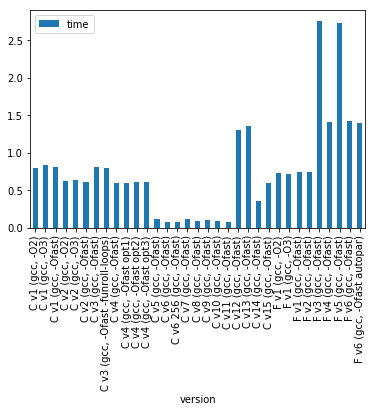

In [5]:
t.plot.bar(x='version', y='time')
plt.ylabel('run time (s)')

There are lots of interesting things to observe here.

The first is that, for this code, there is no significant change in run time between versions of the code compiled with `-O2`, `-O3`, and `-Ofast`. This is seen in the first six results, which are VC1 and VC2 compiled with these three optimization levels. I suspect the operations in the codes are sufficiently simple that any compiler optimizations that can be performed are already covered in `-O2`.

There is quite a large performance improvement between VC1 and VC2. Even at the `-Ofast`, GCC does not automatically unroll loops. It can be requested by adding the `-funroll-loops` compiler option. I tried this in one of the VC3 tests (VC3 is equivalent to VC1 except that the loop over `y` is moved to a separate function). Comparing the 7th and 8th columns in the plot, which correspond to VC3 with and without this compiler option, we see that there is no significant change in run time. It is not clear why the performance did not improve, but the conclusion is that manually unrolling the loops is the safest way to ensure that this performance improvement is obtained.

The performance of VC3 is about the same as that of VC1, and VC4 is about the same as VC2. This indicates that vectorizing the operations was not beneficial in this case. I suspect this is because the performance is memory limited, not compute limited, so making the computations run faster by vectorising them does not affect the overall run time.

Multithreading with OpenMP proves to be very effective. 

In [ ]:
t_align256 = run_timing.run_timing_model_size(num_repeat=30, num_steps=10, model_sizes=[2000], align=256)

In [9]:
t_diff = t_align256.copy()
t_diff.drop(t_diff['version'] == 'C v6 256 (gcc, -Ofast)')
t_diff['diff'] = t_diff['time'] - t['time']
t_diff['perc_diff'] = t_diff['diff'] / t['time']
t_diff.plot.bar(y='perc_diff', x='version', rot=90)

NameError: name 't4' is not defined

In [ ]:
print('C v6 (gcc, -Ofast)', t_align256.loc[t_align256['version'] == 'C v6 (gcc, -Ofast)', 'time'])
print('C v6 256 (gcc, -Ofast)', t_align256.loc[t_align256['version'] == 'C v6 256 (gcc, -Ofast)', 'time'])

In [ ]:
versions=[{'class': VC1_Ofast_gcc, 'name': 'C v1 (gcc, -Ofast)'},
          {'class': VC2_Ofast_gcc, 'name': 'C v2 (gcc, -Ofast)'},
          {'class': VC6_Ofast_gcc, 'name': 'C v6 (gcc, -Ofast)'},
          {'class': VC8_Ofast_gcc, 'name': 'C v8 (gcc, -Ofast)'}]
t_modelsize=run_timing.run_timing_model_size(num_repeat=30, num_steps=10, model_sizes=np.linspace(1000, 5000, 5, dtype=np.int), versions=versions, align=256)

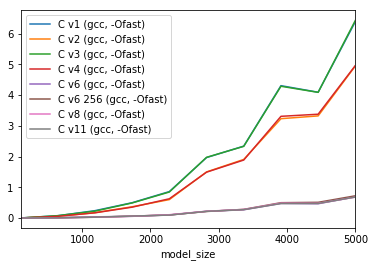

In [6]:
ax=plt.subplot(111)
for v in versions:
    t_modelsize.loc[t_modelsize['version'] == v['name']].plot(x='model_size', y='time', label=v['name'], ax=ax)
plt.ylabel('run time (s)')

In [ ]:
versions=[{'class': VC6_Ofast_gcc, 'name': 'C v6 (gcc, -Ofast)'},
          {'class': VC11_Ofast_gcc, 'name': 'C v11 (gcc, -Ofast)'}]
t_numsteps=run_timing.run_timing_num_steps(num_repeat=30, num_steps=np.linspace(1, 100, 5, dtype=np.int), model_size=2000, versions=versions, align=256)

In [ ]:
ax=plt.subplot(111)
for v in versions:
    t_numsteps.loc[t_numsteps['version'] == v['name']].plot(x='num_steps', y='time', label=v['name'], ax=ax)
plt.ylabel('run time (s)')